In [1]:
import numpy as np
from grid import Grid

g = Grid()
g.print()

-------------------------------
| 0,0 | 1,0 | 2,0 | 3,0 | 4,0 | 
-------------------------------
| 0,1 | 1,1 | 2,1 | 3,1 | 4,1 | 
-------------------------------
| 0,2 | 1,2 | 2,2 | 3,2 | 4,2 | 
-------------------------------
| 0,3 | 1,3 | 2,3 | 3,3 | 4,3 | 
-------------------------------
| 0,4 | 1,4 | 2,4 | 3,4 | 4,4 | 
-------------------------------


In [2]:
e_star = 0.3

# Q-Learning

In [3]:
from actors import QLearning

q = QLearning(g)
q.run(epsilon=e_star)

print('Steps:', q.steps)
print('Rewards:', q.totalReward)

Steps: 227
Rewards: -21


In [4]:
for episodes in range(2000):
    q.resetCount()
    q.run(epsilon=e_star)

print('Episodes:', episodes)
print('Steps:', q.steps)
print('Rewards:', q.totalReward)

Episodes: 1999
Steps: 9
Rewards: 9


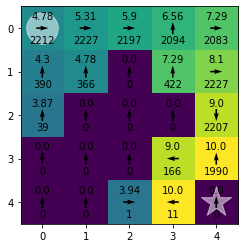

In [5]:
q.plot()

<AxesSubplot: >

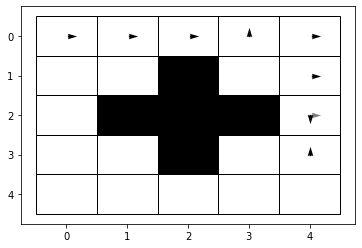

In [6]:
from plot import plotTrajectory
plotTrajectory(q.getTrajectory(), q.g)

# $\mathcal{L}$($\pi_i$|$\xi$)

In [7]:
def generatePi(agent, e=0.1):
    # if not(0 < e < 1):
    #     return -np.inf
    p_a = lambda a, s: (e/4, 1-e+e/4)[a == max(agent.Q[s], key=agent.Q[s].get)] if 0 < e < 1 else 1e-10
    pi = np.array([[p_a(a, s) for a in agent.g.ACTIONS] for s in agent.g.S])
    return pi.reshape(agent.g.size[0], agent.g.size[1], len(agent.g.ACTIONS), order='F')

pi_star = generatePi(q, e_star)
pi_star

array([[[0.075, 0.075, 0.775, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.075, 0.775, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075]],

       [[0.075, 0.075, 0.775, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075]],

       [[0.075, 0.075, 0.775, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.075, 0.075, 0.775, 0.075]],

       [[0.775, 0.075, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.075, 0.075, 0.075, 0.775],
        [0.075, 0.075, 0.075, 0.775]],

       [[0.075, 0.075, 0.775, 0.075],
        [0.075, 0.075, 0.775, 0.075],
        [0.075, 0.775, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075],
        [0.775, 0.075, 0.075, 0.075]]])

In [8]:
def likelihood(pi, e):
    arr = [np.log(pi[x,y][a]) for (x,y), a in e]
    return np.sum(arr)

likelihood(pi_star, q.getTrajectory(2))

-4.629405162476148

## Teste de Sanidade

In [9]:
es = [0.9, 0.7, 0.5] + [e_star] # e_star = 0.3

pis = [generatePi(q, e) for e in es] 

likes = [likelihood(pi, q.getTrajectory(2)) for pi in pis]
p = np.argmax(likes)
print(f'Maior: {p}\n', likes)

Maior: 3
 [-10.483095649996914, -7.6984931046385885, -5.839470575645721, -4.629405162476148]


### Certeza? 

In [10]:
es = [0.9, 0.1, 0.5] + [e_star] # e_star = 0.3
pis = [generatePi(q, e) for e in es]

likes = [likelihood(pi, q.getTrajectory(2)) for pi in pis]
p = np.argmax(likes)

print(f'Maior: {p}\n', likes)

Maior: 1
 [-10.483095649996914, -4.312571785871631, -5.839470575645721, -4.629405162476148]


<AxesSubplot: >

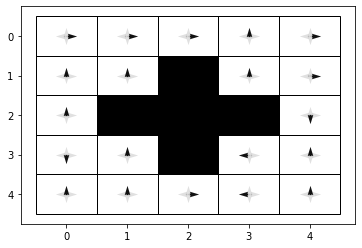

In [11]:
from plot import plotPolicy
plotPolicy(pis[p], q.g)

### Com muitas trajetórias:

In [12]:
from actors import QLearning

agent = QLearning(g)
es = [0.9, 0.1, 0.5]+[e_star] # e_star = 0.3

def teste():
    agent.resetCount()
    agent.run(epsilon=e_star)

    pis = [generatePi(agent, e) for e in es] 
    likes = np.array([likelihood(pi, q.getTrajectory(2)) for pi in pis])
    return likes


total_episodes = 1000
exps = [teste() for _ in range(total_episodes)]
freq = [np.mean([int(np.argmax(v)==i) for v in exps])for i in range(len(es))]
print(np.argmax(np.sum(exps, axis=0)))
print(np.sum(exps, axis=0))
# print(freq)


1
[-10490.08242082  -4381.17922621  -5870.04989598  -4673.77728588]


## Gradiente Descendente

In [13]:
import random 

def gradient(pi,agent):
    # 1/pi(a|s) * dpi(a|s)/de 
    arr = [1/pi[x,y,a] * (.25, -.75)[agent.g.ACTIONS[a]==max(agent.Q[(x,y)], key=agent.Q[(x,y)].get)] for (x,y),a in agent.getTrajectory(2)]
    return np.sum(arr)


def GradientDescent(agent, param=None, learning_rate=.01, decay=.9, precision=1e-4, max_trials=10000):
    """
        Leaning Rate is changed with a Time-based learning schedule
    """
    if param is None:
        param = random.random()

    error = 1+precision
    trials = 0

    pi = generatePi(agent, param)
    l = likelihood(pi, agent.getTrajectory(2))
    while (error > precision) and (trials <= max_trials):
        trials += 1
        new_param = param + learning_rate * gradient(pi, agent)
        new_pi = generatePi(agent, new_param)
        new_l = likelihood(new_pi, agent.getTrajectory(2))
        error = np.abs(new_l - l)
        if new_l >= l:
            # learning_rate += (learning_rate * 0.2) 1 
            learning_rate += learning_rate / (1+decay*trials)
            pi = new_pi
            l = new_l
            param = new_param
        else:
            # learning_rate -= (learning_rate * 0.2) 0.5
            learning_rate -= learning_rate / (1+decay*trials)
            
        yield param, trials, error

def execute(f, all=False):
    result = [(param, trial, error) for param, trial, error  in f]
    return result if all else result[-1]
        

print('estimative', execute(GradientDescent(q)))
data = execute(GradientDescent(q, param=0.9), True)
data#[-1][0]

estimative (0.14819488077830387, 4, 4.017189274563293e-07)


[(0.7264957264957265, 1, 2.47986956890381),
 (0.5462892990767233, 2, 1.7950999078802692),
 (0.3736547103834905, 3, 1.2066975435745313),
 (0.22472837344510174, 4, 0.6456343097393242),
 (0.13611062432190713, 5, 0.11379179142748175),
 (0.13611062432190713, 6, 0.00030367201797165677),
 (0.15734665976776285, 7, 0.0018078432807024925),
 (0.14109805334717085, 8, 0.0007829816103850362),
 (0.14109805334717085, 9, 0.00040734553178811694),
 (0.15477811495863633, 10, 0.00021243551195926358),
 (0.14172781064584705, 11, 1.4052281732901406e-05)]

Text(0.5, 0, 'trial')

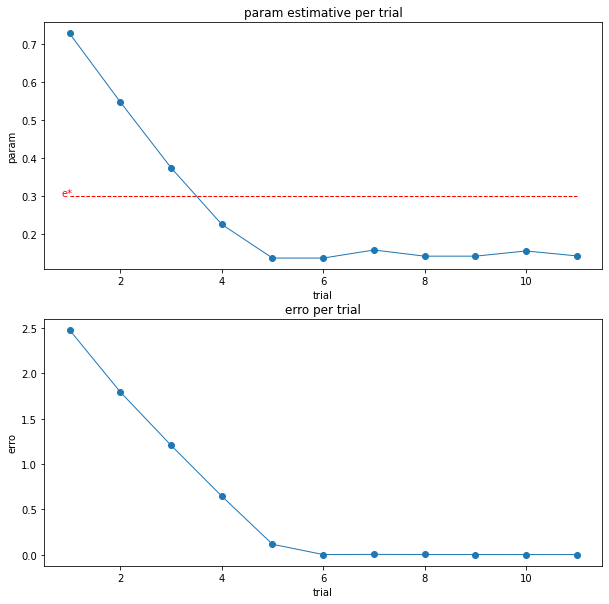

In [14]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(2,1, figsize=(10,10))

axs[0].plot([item[1] for item in data], [item[0] for item in data], linewidth=1, marker='o')
axs[0].plot([item[1] for item in data], [e_star for _ in range(len(data))], linewidth=1, linestyle='dashed', color='red')
axs[0].text(.85, e_star-1e-3, 'e*', color='red')
axs[0].set_title(f'param estimative per trial')
axs[0].set_ylabel('param')
axs[0].set_xlabel('trial')


axs[1].plot([item[1] for item in data], [item[2] for item in data], linewidth=1, marker='o')
axs[1].set_title(f'erro per trial')
axs[1].set_ylabel('erro')
axs[1].set_xlabel('trial')

[(8, 2.84434320058243e-07), (9, 0.1476560958396132), (10, 0.14464747536615313), (10, 0.2665386142866743), (11, 0.23947819915203059), (11, 0.2397467312301795), (12, 0.33329371463586893), (12, 0.44445503744399956), (14, 0.3809329462895003), (14, 0.38095138190282973), (21, 0.5080152191698386), (25, 0.4265691484061314), (34, 0.3932723717864414), (69, 0.4437637308839688), (76, 0.24995211569363324), (88, 0.2225666867245329), (97, 0.20074012435622568), (158, 0.2911502263976726), (306, 0.27731635526381526), (657, 0.3274633296156588)]


[0.08999982933948887,
 0.023208665134829116,
 0.024134406910109995,
 0.0011196643338559564,
 0.00366288837788127,
 0.0036304563974482243,
 0.0011084714342546739,
 0.020867257842947316,
 0.006550141795099143,
 0.006553126231977791,
 0.043270331406275994,
 0.01601974932825332,
 0.008699735338668156,
 0.02066801031767821,
 0.0025047907235434715,
 0.005995918004816629,
 0.009852522912817541,
 7.831849281245116e-05,
 0.0005145477385174411,
 0.0007542344735783238]

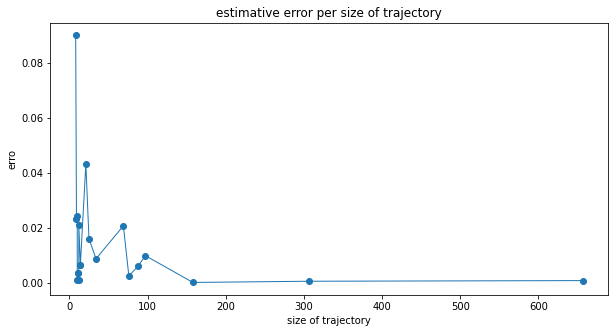

In [15]:
from actors import QLearning

agent = QLearning(g)

def teste():
    agent.resetCount()
    agent.run(epsilon=e_star)

    return len(agent.trajectory), execute(GradientDescent(agent))[0]


total_episodes = 20
exps = sorted([teste() for _ in range(total_episodes)])
print(exps)

fig, axs = plt.subplots(1,1, figsize=(10,5))

axs.plot([item[0] for item in exps], [(e_star-item[1])**2 for item in exps], linewidth=1, marker='o')
axs.set_title(f'estimative error per size of trajectory')
axs.set_ylabel('erro')
axs.set_xlabel('size of trajectory')

[(e_star-item[1])**2 for item in exps]

## Gerador de Trajetórias

In [16]:
def generatePi(g, q_values,  e=0.1):
    p_a = lambda a, s: (e/4, 1-e+e/4)[a == max(q_values[s], key=q_values[s].get)] if 0 < e < 1 else 1e-10
    pi = np.array([[p_a(a, s) for a in g.ACTIONS] for s in g.S])
    return pi.reshape(g.size[0], g.size[1], len(g.ACTIONS), order='F')


In [17]:
import random 

def gradient(pi, trajectory, q_values, g):
    # 1/pi(a|s) * dpi(a|s)/de 
    arr = [1/pi[x,y,a] * (.25, -.75)[g.ACTIONS[a]==max(q_values[(x,y)], key=q_values[(x,y)].get)] for (x,y),a in trajectory]
    return np.sum(arr)


def GradientDescent(trajectory, q_values, g, param=None, learning_rate=.01, decay=.9, precision=1e-4, max_trials=10000):
    """
        Leaning Rate is changed with a Time-based learning schedule
    """
    if param is None:
        param = random.random()

    error = 1+precision
    trials = 0

    pi = generatePi(g, q_values, param)
    l = likelihood(pi, trajectory)
    while (error > precision) and (trials <= max_trials):
        trials += 1
        new_param = param + learning_rate * gradient(pi, trajectory, q_values, g)
        new_pi = generatePi(g, q_values, new_param)
        new_l = likelihood(new_pi, trajectory)
        error = np.abs(new_l - l)
        if new_l >= l:
            # learning_rate += (learning_rate * 0.2) 
            learning_rate += learning_rate / (1+decay*trials)
            pi = new_pi
            l = new_l
            param = new_param
        else:
            # learning_rate -= (learning_rate * 0.2)
            learning_rate -= learning_rate / (1+decay*trials)
            
        yield param, trials, error

def execute(f, all=False):
    result = [(param, trial, error) for param, trial, error  in f]
    return result if all else result[-1]
        

print('estimative', execute(GradientDescent(q.getTrajectory(2), q.Q, g)))

estimative (0.15348569836839793, 6, 2.5127541526615005e-05)


In [18]:
import random
def generateTrajetory(pi, g,  kind=0, size=10):
    s = (0,0)

    arr = []
    for t in range(size):
        a  = random.choices(g.ACTIONS, pi[s], k=1)[0]
        if kind in ['values', 0]:
            step =  (s, a)
        elif kind in ['indexes', 1]:
            step =  (g.S.index(s), g.ACTIONS.index(a))
        elif kind in ['states values', 2]:
            step =  (s, g.ACTIONS.index(a))
        elif kind in ['action values', 3]:
            step =  (g.S.index(s), a)

        s,_,_ = g.transition(s,  a)

        arr.append(step)

    return arr

trajectory = generateTrajetory(pi_star, g)
trajectory

[((0, 0), (1, 0)),
 ((1, 0), (1, 0)),
 ((2, 0), (1, 0)),
 ((3, 0), (0, -1)),
 ((4, 0), (1, 0)),
 ((4, 1), (-1, 0)),
 ((4, 0), (0, -1)),
 ((4, 0), (1, 0)),
 ((4, 1), (0, 1)),
 ((3, 1), (0, -1))]

Text(0.5, 0, 'size of trajectory')

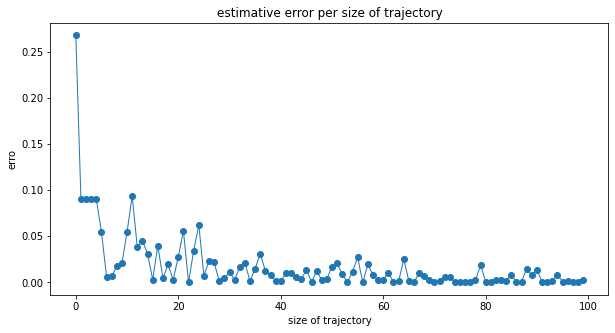

In [19]:
fig, axs = plt.subplots(1,1, figsize=(10,5))

exps = [execute(GradientDescent(generateTrajetory(pi_star, g, 2, t), q.Q, g))[0] for t in range(100)]
x = [i for i in range(len(exps))]
y = [(e_star-item)**2 for item in exps]


axs.plot(x,y, linewidth=1, marker='o')
axs.set_title(f'estimative error per size of trajectory')
axs.set_ylabel('erro')
axs.set_xlabel('size of trajectory')

# [(e_star-item[1])**2 for item in exps]
# exps

Text(0.5, 0, 'size of trajectory')

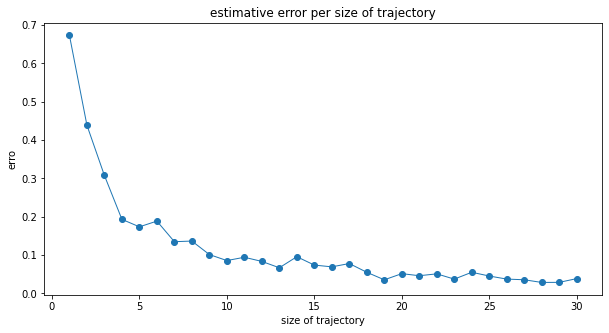

In [35]:
fig, axs = plt.subplots(1,1, figsize=(10,5))

n = 100
trajectory_size = 30
x = [n+1 for n in range(trajectory_size)]

sums = np.zeros(trajectory_size, dtype='float64')

for i in range(n):
    exps = np.array([execute(GradientDescent(generateTrajetory(pi_star, g, 2, t+1), q.Q, g))[0] for t in range(trajectory_size)])
    sums += (e_star-exps)**2
    
y = sums/trajectory_size

axs.plot(x,y, linewidth=1, marker='o')
axs.set_title(f'estimative error per size of trajectory')
axs.set_ylabel('erro')
axs.set_xlabel('size of trajectory')

# [(e_star-item[1])**2 for item in exps]
# exps

### Muitas Trajetórias de Tamanho Fixo  

In [36]:
es = [0.9, 0.1, 0.5]+[e_star] # e_star = 0.3

def teste():
    trajectory = generateTrajetory(pi_star, g, 2, 10)
    # execute(GradientDescent(trajectory, q.Q, g))[0]
    pis = [generatePi(g, q.Q, e) for e in es] 
    likes = np.array([likelihood(pi, trajectory) for pi in pis])
    return likes


total_episodes = 1000
exps = [teste() for _ in range(total_episodes)]
freq = [np.mean([int(np.argmax(v)==i) for v in exps])for i in range(len(es))]
print(np.argmax(np.sum(exps, axis=0)))
print(np.sum(exps, axis=0))
# print(freq)


3
[-12072.93304307  -8965.56632266  -8348.63203995  -7843.21743045]
